# Triplet Trashbin Classifier 

## Import libraries and main variables

Notebook di presentazione dello studio della realizzazione di una rete Triplet utilizzando `pytorch-lighting`

In [1]:
from libs.Dataset import TripletTrashbinDataModule
from libs.Model import TripletNetwork, TripletNetworkV2, evaluating_performance
from torchvision.models import squeezenet1_1
import torch
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import progress
from os.path import join
import warnings # or to ignore all warnings that could be false positives
warnings.filterwarnings("ignore")
from pytorch_lightning.utilities.warnings import PossibleUserWarning
warnings.filterwarnings("ignore", category=PossibleUserWarning)

In [2]:
data_img_size = 224
data_batch_size = 256
# otherwise, return warning
n_workers = 0  # os.cpu_count()
LOGS_FOLDER = "logs"
MAIN_MODELS_FOLDER = "models"
MAX_EPOCHS = 61

# carico come dataloader solo una versione del dataset
dm = TripletTrashbinDataModule(img_size=data_img_size,num_workers=n_workers)
dm.setup()

Adatto SqueezeNet, per farlo funzionare come feature extractor, sostituendo il classificatore con il modulo Identity che ritornerà l'input senza alcuna manipolazione.

In [5]:
squeezeNet = squeezenet1_1(pretrained=True)
squeezeNet.classifier = nn.Identity()

squeezeNet(torch.zeros(1,3,data_img_size,data_img_size)).shape

torch.Size([1, 86528])

## Finding best parameters

Imposto il learning rate con quello trovato nella precedente report

In [6]:
tripletNetwork = TripletNetwork(squeezeNet, lr=0.002, batch_size=data_batch_size)

Batch size finder

In [7]:
trainer = pl.Trainer(auto_scale_batch_size="power", max_epochs=-1)
trainer.tune(tripletNetwork, datamodule=dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Batch size 2 succeeded, trying batch size 4
Batch size 4 succeeded, trying batch size 8
Batch size 8 succeeded, trying batch size 16
Batch size 16 succeeded, trying batch size 32
Batch size 32 succeeded, trying batch size 64
Batch size 64 succeeded, trying batch size 128
Batch size 128 succeeded, trying batch size 256
Batch size 256 succeeded, trying batch size 512
Batch size 512 succeeded, trying batch size 1024
Batch size 1024 succeeded, trying batch size 2048
Batch size 2048 succeeded, trying batch size 4096
Batch size 4096 succeeded, trying batch size 8192
Batch size 6600 succeeded, trying batch size 13200
Finished batch size finder, will continue with full run using batch size 6600
Restoring states from the checkpoint path at /Users/danilo/GitHub/deep-learning/.scale_batch_size_cd046314-3d33-42b7-8bb2-55d987f7354e.ckpt


{'scale_batch_size': 6600}

Learning rate finder

In [7]:
trainer = pl.Trainer(auto_lr_find=True)
lr_finder = trainer.tune(tripletNetwork, datamodule=dm)
lr_finder

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 50 steps due to diverging loss.
Restoring states from the checkpoint path at /Users/danilo/GitHub/triplet-trashbin-classifier/.lr_find_d07c4002-f70a-49de-bfd2-97a2aa460a37.ckpt
Learning rate set to 7.585775750291837e-08


{'lr_find': <pytorch_lightning.tuner.lr_finder._LRFinder at 0x139b93940>}

## Models

Loading models from checkpoint and visualize plot. Evaluating classification

### Triplet Margin Loss

In [3]:
ckpt_1 = join(MAIN_MODELS_FOLDER, "TripletMarginLoss-epoch-60.ckpt")

tripletNetwork_tml = TripletNetwork.load_from_checkpoint(checkpoint_path=ckpt_1) 

logger_tml = TensorBoardLogger("models/logs", name="TripletMarginLoss")

trainer = pl.Trainer(gpus=0,
                    max_epochs=MAX_EPOCHS,
                    callbacks=[progress.TQDMProgressBar()],
                    logger=logger_tml,
                    accelerator="auto",
                    devices=1 # recommended for validation
                    )

trainer.validate(model=tripletNetwork_tml, ckpt_path=ckpt_1, datamodule=dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at models/TripletMarginLoss-epoch-60.ckpt
Loaded model weights from checkpoint at models/TripletMarginLoss-epoch-60.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       valid/loss           1.0833001136779785
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'valid/loss': 1.0833001136779785}]

100%|██████████| 124/124 [07:10<00:00,  3.47s/it]


Classification error 0.8661616161616161


100%|██████████| 124/124 [07:15<00:00,  3.52s/it]


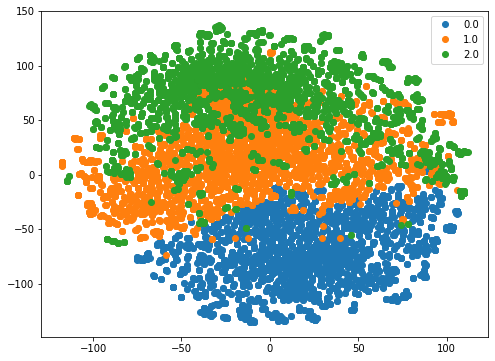

In [4]:
evaluating_performance(tripletNetwork_tml, dm)

### Triplet Margin with Distance Loss

In [6]:
ckpt_2 = join(MAIN_MODELS_FOLDER, "TripletMarginWithDistanceLoss-epoch-30.ckpt")

tripletNetwork_tmwdl = TripletNetworkV2.load_from_checkpoint(checkpoint_path=ckpt_2) 

logger_tmwdl = TensorBoardLogger("models/logs", name="TripletMarginWithDistanceLoss")

trainer = pl.Trainer(gpus=0,
                    max_epochs=MAX_EPOCHS,
                    callbacks=[progress.TQDMProgressBar()],
                    logger=logger_tmwdl,
                    accelerator="auto",
                    devices=1 # recommended for validation
                    )

trainer.validate(model=tripletNetwork_tmwdl, ckpt_path=ckpt_2, datamodule=dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at models/TripletMarginWithDistanceLoss-epoch-30.ckpt
Loaded model weights from checkpoint at models/TripletMarginWithDistanceLoss-epoch-30.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       valid/loss           1.3573863506317139
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'valid/loss': 1.3573863506317139}]

100%|██████████| 124/124 [08:01<00:00,  3.88s/it]


Classification error 0.8888888888888888


100%|██████████| 124/124 [07:45<00:00,  3.75s/it]


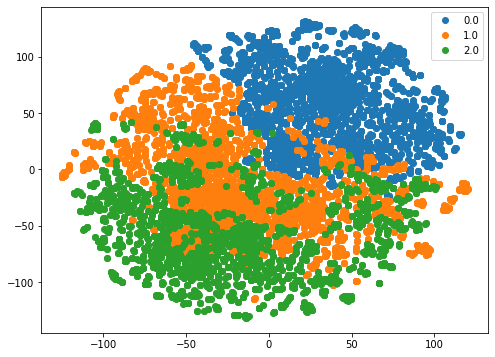

In [8]:
evaluating_performance(tripletNetwork_tmwdl, dm)